# Change Detection - Deep Learning on Image Ratios

### Summary
This notebook trains a Convolutional Neural Network (CNN) to identify building change from the pixel ratios between before/after [Sentinel-2](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/overview) imagery. For a better understanding of the ratio method begin with `change_detection.ipynb`. The model is trained on the pixel ratios of pre- & post-disaster imagery for events in the Caribbean. Ground truth building damage data is gathered from [Copernicus EMS](https://emergency.copernicus.eu/mapping/map-of-activations-rapid#zoom=3&lat=29.18235&lon=-70.57787&layers=BT00).

If you already have a trained model and simply wish to evaluate it's output at a new location, skip to section 5 after section 1.

### Contents
- 1 - [Visualise Ratio & Damage Labels](#trLabels)
- 2 - [Training Images](#trImages)
- 3 - [Build Model](#buildModel)
- 4 - [Train Model](#trainModel)
- 5 - [Predictions](#Predictions)
- 6 - [Evaluate Prediction Accuracy](#PredictionAccuracy)
- 7 - [Test Location](#TestLocation)

### Requirements
- Lat/Long of desired location
- Before and after dates for change detection
- Output of damages at location if evaluating model

__________________________
### Initialisation steps - Define variables & import packages

In [1]:
## Define location, dates and satellite
location = 'Roseau' # Name for saved .pngs
lat, lon = 15.3031, -61.3834 # Center of Area of Interest 
zoom = 15 # Map tile zoom, default 16
st_date, end_date = ['2017-08-15', '2017-10-01'], ['2017-09-15', '2017-12-01'] # Timeframes for before-after imagery: start 1, start 2; end 1 ,end 2
satellite = "sentinel-2:L1C" # Descartes product name
bands = ['red','green','blue'] # Bands used for visualisation
cloudFraction = 0.05 # May need adjusted to get images from appropriate dates for Sentinel


## Testing 
preModel = "models/optimalModel" # Use a pre-trained model - if training leave as ""
deployed = False # Run model for area without damage assessment

# If a damage geojson already exists for location - else leave as ""
dmgJsons = ""  # Damage file name qualifying location and area size if already exists

# Form new damage assessment json from Copernicus EMS database
dmgAssess = "gradings/EMSR246_04ROSEAU_02GRADING_v1_5500_settlements_point_grading.dbf" # Copernicus EMS damage assessment database location (.dbf file needs .prj,.shp,.shx in same directory)
grades = ['Completely Destroyed','Highly Damaged'] # Copernicus EMS labels included, options: 'Not Applicable','Negligible to slight damage', 'Moderately Damaged', 'Highly Damaged'
area = 0.0004 # Building footprint diameter in lat/long degrees (0.0001~10m at equator)
newDmgLocation = 'geojsons/'+location+'Damage'+str(area)[2:]+'g'+str(len(grades))+'.geojson' # Location for newly created damage .json


## Training - Model training input
resolution = 10 # Resolution of satellite imagery -> 10 if Sentinel
tilesize, pad, trainArea = 16, 0, 0.0003 # Tilesize for rastering -> 32 as default, tile padding
records = "records/"+location+str(trainArea)[2:]+"g"+str(len(grades))+"x"+str(tilesize)+"p"+str(pad)+".tfrecords" # Name of file for training labels
learning_rate, epochs, batch_size, n_samples = 1e-3, 50, 8, 2000 # Model training parameters
modelName = "models/"+location+"g"+str(len(grades))+"ts"+str(tilesize)+"pd"+str(pad)+"lr"+str(learning_rate)[2:]+"e"+str(epochs)+"bs"+str(batch_size)+"a"+str(trainArea)[2:]+"n"+str(n_samples) if preModel is "" else preModel # Define output model name

In [2]:
# Import packages
# Python libraries
import IPython
import ipywidgets
import ipyleaflet
import json
import random
import os
import geojson
import numpy as np
import pandas as pd
import geopandas as gpd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Library functions
from tqdm import tqdm
from ipyleaflet import Map, GeoJSON, GeoData, LegendControl
from shapely.geometry import Polygon, Point
from tensorflow.keras.models import load_model

# Descartes Labs
import descarteslabs as dl
import descarteslabs.workflows as wf

# Custom functions
from utils import make_ground_dataset_from_ratio_polygons, get_center_location
from unet import UNet

______________________
<a id='trLabels'></a>
## 1. Visualise Ratio & Damage Labels
First let's extract the training labels from EMS Copernicus data and visualise them. Use magic markers below map to scale imagery properly.

In [3]:
# Function to create damage json from EMS Copernicus database
if not deployed:
    def createDmgJson(dmgAssess, grades,area,dmgJsons):
        settlements = gpd.read_file(dmgAssess).to_crs({'init': 'epsg:4326'}) # Read from file
        color_dict = {'Not Applicable':'green','Negligible to slight damage':'blue', 'Moderately Damaged':'yellow', 'Highly Damaged':'orange', 'Completely Destroyed':'red'}
        damage = settlements[settlements.grading.isin(grades)]  # Filter settlements to be within specified damage grade and location polygon

        if damage.geometry[damage.index[0]].type is not 'Polygon': # Gets point assessment damages into geojson file
            features = []
            for i in tqdm(damage.index):
                poly = Polygon([[damage.geometry.x[i], damage.geometry.y[i]], [damage.geometry.x[i]+area, damage.geometry.y[i]], [damage.geometry.x[i]+area, damage.geometry.y[i]+area], [damage.geometry.x[i], damage.geometry.y[i]+area], [damage.geometry.x[i], damage.geometry.y[i]]])
                features.append(geojson.Feature(properties={"Damage": damage.grading[i]}, geometry=poly))

            fc = geojson.FeatureCollection(features)
            with open(dmgJsons, 'w') as f: geojson.dump(fc, f)

        else:
            with open(dmgJsons, 'w') as f: geojson.dump(damage, f) # Puts polygon assessments into geojson file

    # If geojson of damage from EMS Copernicus does not exist - create one
    if not os.path.exists(dmgJsons) and not os.path.exists(newDmgLocation): createDmgJson(dmgAssess,grades,area,newDmgLocation)

    try: fc = gpd.read_file(dmgJsons) # Read training label data from damage file
    except: fc, dmgJsons = gpd.read_file(newDmgLocation), newDmgLocation

In [4]:
# Initialise map
m1 = wf.interactive.MapApp()
m1.center, m1.zoom = (lat, lon), zoom

# Define function which displays satellite imagery on map
def getImage(time,bands,opacity,mapNum):
    img = wf.ImageCollection.from_id(satellite,start_datetime=st_date[time], end_datetime=end_date[time])
    if 'sentinel' in satellite: # Use sentinel cloud-mask band if available
        img = img.filter(lambda img: img.properties["cloud_fraction"] <= cloudFraction)
        img = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1))
    mos = (img.mosaic().pick_bands(bands))
    globals()['mos_'+str(time+1)+str(bands)] = mos
    display = mos.visualize('Image '+str(time+1)+' '+str(bands), map=mapNum)
    display.opacity = opacity

# Display before and after images for selected bands - needs to be RGB for training this model
for i in range(len(st_date)): getImage(i,bands,0.7,m1)
    
# Calculate logarithmic ratio for RGB images and display
ratio = wf.log10(globals()['mos_1'+str(bands)] / globals()['mos_2'+str(bands)])
rdisplay = ratio.visualize('Ratio' ,map=m1)
rdisplay.opacity = 0

# Plot damage assessment data
if not deployed:
    geo_data = GeoData(geo_dataframe = fc, style={"color": "red", "fillOpacity": 0.4}, hover_style={"fillOpacity": 0.5})
    m1.add_layer(geo_data)

    # Legend
    m1.add_control(LegendControl({"Recorded Damage":"#FF0000"})) 

m1 # Display map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


 Sections 2-4 are for training a new model. If assessing perfomance on new location with damage assessments jump to [section 5](#Predictions). If evaluating change over a new area without ground data (i.e. deployed = True), jump to [section 7](#TestLocation)

______________________
<a id='trImages'></a>
## 2. Training images
Next, let's make an image dataset for training. The training data for this segmentation model will be comprised of RGB image tiles with corresponding target rasters of the same size. Targets are binary rasters where 1 indicates the presence of a damaged building and 0 indicates the absence. The function below tiles the region covering the labels, it extracts the corresponding tile of the ratio image displayed above, and makes the corresponding target raster. Training pixel size can be varied in the variables section. These training data are saved as .tfRecords for efficient model training.

This step will take 5-10 minutes. The dataset only has to be created once. In case the notebook is re-run with same parameters as a previous run, this cell will be skipped.

In [ ]:
if not os.path.exists(records): # If records have not already been created
    if not os.path.exists("records"): os.mkdir("records") # Create directory for record output if not existing
    trainJsons = 'geojsons/'+location+'Damage'+str(trainArea)[2:]+'g'+str(len(grades))+'.geojson'
    if not os.path.exists(trainJsons): createDmgJson(dmgAssess,grades,trainArea,trainJsons)
    n_samples = make_ground_dataset_from_ratio_polygons(
        ratio,
        trainJsons,
        products=satellite,
        bands=bands,
        resolution=resolution,
        tilesize=tilesize,
        pad=pad,
        start_datetime=st_date[0],
        end_datetime=end_date[0],
        out_file=records,
    )

In order to read the TFRecords the data structure and a parsing function is defined next.

In [6]:
# Define the features in the TFRecords file
features = {
    "image/image_data": tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
    "image/height": tf.io.FixedLenFeature([], tf.int64),
    "image/width": tf.io.FixedLenFeature([], tf.int64),
    "image/channels": tf.io.FixedLenFeature([], tf.int64),
    "target/target_data": tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
    "target/height": tf.io.FixedLenFeature([], tf.int64),
    "target/width": tf.io.FixedLenFeature([], tf.int64),
    "target/channels": tf.io.FixedLenFeature([], tf.int64),
    "dltile": tf.io.FixedLenFeature([], tf.string),
}

def parse_example(example_proto):
    image_features = tf.io.parse_single_example(example_proto, features)

    img_height = tf.cast(image_features["image/height"], tf.int32)
    img_width = tf.cast(image_features["image/width"], tf.int32)
    img_channels = tf.cast(image_features["image/channels"], tf.int32)

    target_height = tf.cast(image_features["target/height"], tf.int32)
    target_width = tf.cast(image_features["target/width"], tf.int32)
    target_channels = tf.cast(image_features["target/channels"], tf.int32)

    image_raw = tf.reshape(
        tf.squeeze(image_features["image/image_data"]),
        tf.stack([img_height, img_width, img_channels]),
    )

    target_raw = tf.reshape(
        tf.squeeze(image_features["target/target_data"]),
        tf.stack([target_height, target_width, target_channels]),
    )

    return image_raw, target_raw

Let's create a simple data pipeline to visualize some samples from the dataset.

In [7]:
# Create a TFRecordDataset to read images from these TFRecords
data = tf.data.TFRecordDataset(records).map(parse_example, num_parallel_calls=4)
data_viz = iter(data.batch(1))

In [ ]:
# Visualize samples. You can re-run this cell to iterate through the dataset.
img, trg = next(data_viz)
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
rat = ax[0].imshow(np.exp(img.numpy()).astype(np.float)[0])
lab = ax[1].imshow(trg.numpy().astype(np.uint8)[0].squeeze())
rat_title = ax[0].set_title("Ratio pixels")
lab_title = ax[1].set_title('Building damages (yellow)')

The above display shows the first training sample, displaying the image and corresponding target. Each image can have one or more damaged buildings or can be a negative image without any. You can iterate through the training images by re-running the cell above multiple times.
______________________

<a id='buildModel'></a>
## 3. Build Model

The model architecture is a [UNet classifier](https://arxiv.org/abs/1505.04597). We'll use a pre-built implementation in [TensorFlow](https://www.tensorflow.org/)_v2 / Keras . 

In [51]:
# Insure tensorflow is version 2
assert int(tf.__version__[0]) > 1, "Please install Tensorflow 2"

learning_rate, epochs, batch_size, n_samples = 1e-4, 10, 2, 300
modelName = "models/"+location+"g"+str(len(grades))+"ts"+str(tilesize)+"pd"+str(pad)+"lr"+str(learning_rate)[2:]+"e"+str(epochs)+"bs"+str(batch_size)+"a"+str(trainArea)[2:]+"n"+str(n_samples) if preModel is "" else preModel # Define output model name

# Build the model. We could just use the base_model but then the input size would be fixed once we load a saved model. 
# In order to be able to predict on larger tiles we create an input layer with no fixed size
base_model = UNet()
inputs = tf.keras.layers.Input(shape=(None, None, 3))
model = tf.keras.Model(inputs=inputs, outputs=base_model(inputs))

We will now compile the model and output a summary which takes three arguments:
- Optimizer: A reasonable choice of optimizer is [Adam](https://arxiv.org/abs/1412.6980v8) - it performs well in most real-world scenarios.
- Loss function: We will use [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) as a loss as it is suitable for binary classification problems.
- Metric: From our experience using the simple ratio method, 0.7 precision should be achievable but a big problem is increasing recall. Therefore we will focus on this metric for training.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["binary_accuracy","Precision","Recall"]#,"Precision","Recall"]#tfa.metrics.F1Score(num_classes=2, threshold=0.5)#tf.keras.metrics.RecallAtPrecision(precision=0.7) #["accuracy"]
)
model.summary()

______________________
<a id='trainModel'></a>
## 4. Train Model

We will now train the model using Stochastic Gradient Descent (SGD) with data batches.  Before training the data is shuffled before splitting into a training and validation set.

In [53]:
# Get train/validation set sizes
n_train_samples = int(0.8 * n_samples)
n_val_samples = n_samples - n_train_samples

# Get data and apply transform
data = tf.data.TFRecordDataset("records/HaitiAbricots0002g3x16p0.tfrecords").map(parse_example, num_parallel_calls=4)
def type_transform(feature, target):
    return tf.cast(feature, tf.float32), tf.cast(target, tf.float32)
data = data.map(type_transform, num_parallel_calls=4)

# # Concatenate second training location records if wanted
# data2 = tf.data.TFRecordDataset("records/HaitiAbricots0002g3x32.tfrecords").map(parse_example, num_parallel_calls=4)
# data2 = data2.map(type_transform, num_parallel_calls=4)
# data = data.concatenate(data2)

# # Concatenate third training location records if wanted
# data3 = tf.data.TFRecordDataset("records/HaitiLesCayes0002g2x32.tfrecords").map(parse_example, num_parallel_calls=4)
# data3 = data3.map(type_transform, num_parallel_calls=4)
# data = data.concatenate(data3)

# Shuffle the data and split into train and validation set
data = data.shuffle(buffer_size=300, seed=1)
data_train = data.take(n_train_samples).repeat().batch(batch_size)
data_val = data.skip(n_train_samples).repeat().batch(batch_size)

Let's train the model! This will take a while depending on training set size and number of epochs requested.

In [ ]:
with tf.device('/gpu:0'):
    history = model.fit(
        data_train,
        steps_per_epoch=n_train_samples // batch_size,
        validation_data=data_val,
        validation_steps=n_val_samples // batch_size,
        epochs=epochs,
    )

In [ ]:
# Save the model to folder
if not os.path.exists("models"): os.mkdir("models")
tf.saved_model.save(model, modelName)

In [56]:
# Save to Descartes Labs storage if you so desire
print(modelName) # You'll have to copy this into both parts of the !zip command below
!zip -r copyHere.zip copyHere
print('Upload model to Storage')
storage = dl.Storage()
storage.set_file(modelName, modelName+".zip")
os.remove(modelName+".zip")

Let's plot the training history. Our model's loss should go down smoothly while the accuracy should go up.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(history.history["loss"], label="train")
ax[0].plot(history.history["val_loss"], label="val")
ax[1].plot(history.history[list(history.history.items())[1][0]], label="train")
ax[1].plot(history.history[list(history.history.items())[3][0]], label="val")

ax[0].set_title("model loss")
ax[1].set_title("model accuracy")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel(list(history.history.items())[1][0])
ax[0].legend(loc="upper right")

p, r = history.history["precision"][epochs-1], history.history["recall"][epochs-1]
f1 = 2*(p*r)/(p+r)

print("Training metrics - Precision: ",p,", Recall: ",r,", F1 Score: ",f1)

plt.show()

In [ ]:
n_test_samples = 500
data_test = tf.data.TFRecordDataset("records/HaitiPortSalut0004g3x32.tfrecords").map(parse_example, num_parallel_calls=4)
data_test = data_test.map(type_transform, num_parallel_calls=4)
data_test = data_test.shuffle(buffer_size=1000, seed=1)
data_test = data_test.take(n_test_samples).repeat().batch(batch_size)

results = model.evaluate(data_test,
                         batch_size=8,
                         steps=n_test_samples//batch_size)

p, r = results[2], results[3]
f1 = 2*(p*r)/(p+r)
print("F1: ",f1)

________________
<a id='Predictions'></a>
## 5. Predictions

Let's take a look at some predictions made by our model. We will retrieve a tile of the ratio image from our specified test location and get the predicted change from our model. If you want to use a model you've saved to Descartes Storage mark `dl_storage` as True in next box.

In [5]:
# Function for loading model from Descartes Labs storage
dl_storage = False
def load_model_from_storage(storage_key):
    """Load TF model from DL.Storage"""
    import tempfile
    model_zip = tempfile.NamedTemporaryFile()
    model_dir = tempfile.TemporaryDirectory()
    dl.Storage().get_file(storage_key, model_zip.name)
    os.system("unzip {} -d {}".format(model_zip.name, model_dir.name))
    os.path.join(model_dir.name, "saved_model")
    model_zip.close()
    model_dir.cleanup()

    return model

In [6]:
# Function retrieving appropriate tile of the ratio
def get_ratio_image(dltile_key,ratio,tilesize,bands):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products=satellite, start_datetime=st_date[0], end_datetime=end_date[0])
    return ratio.compute(ctx).ndarray.reshape(tilesize,tilesize,len(bands)) 

# Function retrieving desired tile from Sentinel imagery for display
def get_sentinel_image(dltile_key, bands):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products=satellite, start_datetime=st_date[0], end_datetime=end_date[0])
    im = sc.mosaic(bands=bands, ctx=ctx, bands_axis=-1)
    return im, ctx

For simplicity, we'll put all of the necessary steps into a single function that loads the model, retrieves the ratio tile for a location specified by `dltile_key`, pre-processes the tile and performs model prediction.

In [7]:
def predict_image(dltile_key,ratio,tilesize,bands):
    print("Predict on image for dltile {}".format(dltile_key))

    # load model
    model = load_model_from_storage(modelName) if dl_storage else load_model(modelName)

    # get imagery
    im = get_ratio_image(dltile_key,ratio,tilesize,bands)

    # add batch dimension
    im = np.expand_dims(im, axis=0).astype(np.float32)

    # predict
    pred = model.predict(im)

    return im, pred

In [8]:
# Type in here if you would like to change the coordinates from the map center defined in variables section.
lat, lon, tilesize = lat, lon, tilesize
tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution=resolution, tilesize=tilesize, pad=pad) # Convert coordinates to nearest descartes labs tile with size of our choosing

im, pred = predict_image(tile.key,ratio,tilesize,bands) # Run prediction function for tile
sent, ctx = get_sentinel_image(tile.key,bands) # Get Sentinel imagery for tile

Predict on image for dltile 16:0:10.0:20:1084:10578

Job ID: fe775619e91bb43d41cfcd52a0de773ac0720ebe657fbb9d
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  

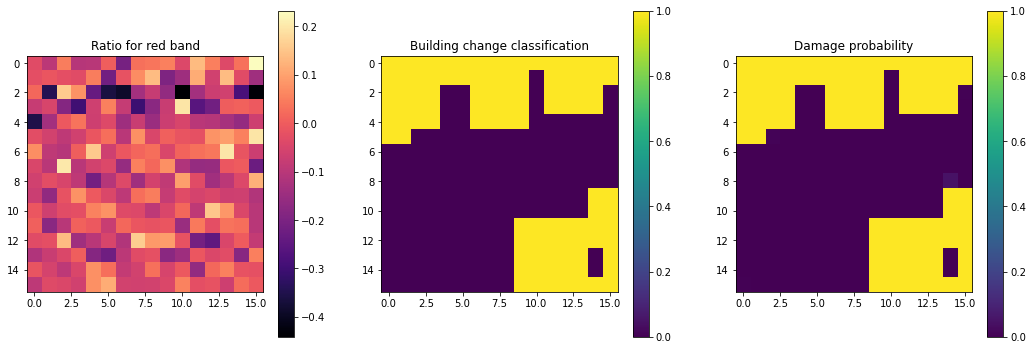

In [9]:
# Simple plot of predictions 
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
visBand = 0 # Choose band to visualise ratio of

# Plot ratio of chosen band
a = ax[0].imshow((im.data[0,:,:,visBand].squeeze()).astype("float"), cmap ='magma')
fig.colorbar(a, ax = ax[0])
a_tit = ax[0].set_title("Ratio for "+bands[visBand]+" band")

# Plot identified change
disting = pred > 0.2
b = ax[1].imshow(disting[0].squeeze().astype("float"))
fig.colorbar(b, ax = ax[1])
b_tit = ax[1].set_title("Building change classification")

# Plot confidence in prediction 
c = ax[2].imshow(pred[0].squeeze().astype("float"))
fig.colorbar(c, ax = ax[2])
c_tit = ax[2].set_title("Damage probability")

In [10]:
# Extract latitude & longitude of each pixel in prediction (whether true or false)
bounds, disting = ctx.bounds, disting[0,:,:,0] if len(disting.shape) == 4 else disting # Get bounds from tile and reduce extra dimensionality of classification matrix
lats, longs = np.linspace(bounds[3],bounds[1],disting.shape[0]), np.linspace(bounds[0],bounds[2],disting.shape[1]) # Vector of lat, longs

# Create matrix of coordinates for pixels with change detected
xm, ym = np.meshgrid(longs,lats)
xc, yc = xm*(disting), ym*(disting)

# Get geodataframe for pixel points
df = pd.DataFrame(columns=['Northing', 'Easting'])
for i,j in zip(np.nonzero(xc)[0], np.nonzero(xc)[1]):
    df = df.append({'Northing': yc[i][j],'Easting': xc[i][j]}, ignore_index=True)
det = gpd.GeoDataFrame(df, crs={'init':ctx.bounds_crs}, geometry=gpd.points_from_xy(df.Easting, df.Northing)).to_crs({'init': 'epsg:4326'})

In [11]:
# Initialise map
m3 = wf.interactive.MapApp()
m3.center, m3.zoom = (lat, lon), zoom

getImage(1,bands,0.7,m3) # Display sentinel imagery using function from map 1

# Add layer for predicted building damages
geo_data = GeoData(geo_dataframe = det, style={'color': 'yellow', 'radius':2, 'fillColor': 'yellow', 'opacity':1, 'weight':1.9, 'dashArray':'2', 'fillOpacity':1},
                    hover_style={'fillColor': 'red' , 'fillOpacity': 1},
                    point_style={'radius': 3, 'color': 'yellow', 'fillOpacity': 0.7, 'fillColor': 'yellow', 'weight': 3},
                    name = 'Damages')
m3.add_layer(geo_data)

# Plot bounding box for damage search
poly = gpd.GeoSeries(Polygon.from_bounds(ctx.bounds[0],ctx.bounds[1],ctx.bounds[2],ctx.bounds[3]), crs={'init':ctx.bounds_crs}).to_crs(epsg=4326)
box = GeoData(geo_dataframe = gpd.GeoDataFrame(geometry = poly.envelope), style={'color':'black','fillOpacity':0, 'opacity':0.9})
m3.add_layer(box)

# Legend
m3.add_control(LegendControl({"Detected Change":"#FFFF00","Search Area":"#000000"}))

m3


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


____________
<a id='PredictionAccuracy'></a>
## 6. Evaluate Prediction Accuracy
Finally, let's compare the prediction to known damages from Copernicus EMS assessments and evaluate the effectiveness of our learnt model.

As in the ratio method notebook (`change_detection.ipynb`) we determine the accuracy by evaluating the correspondance of detected change pixels to building footprints. The metrics are as follows:
- Precision (proportion of damage detected): $P = \frac{True Positives}{True Positives + False Positives}$
- Recall (proportion of detections corresponding to damage): $R = \frac{True Positives}{True Positives + False Negatives}$
- F1 Score: $F1 = 2x\frac{P*R}{P+R}$

In [12]:
# Load building damages and filter for within detection area
dmg = gpd.read_file(dmgJsons)
filtered = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
tilePoly = gpd.GeoSeries(Polygon.from_bounds(ctx.bounds[0],ctx.bounds[1],ctx.bounds[2],ctx.bounds[3]), crs={'init':ctx.bounds_crs}).to_crs(epsg=4326).geometry[0]
for i in dmg.index: 
    if dmg.geometry[i].centroid.within(tilePoly):
        filtered = filtered.append(dmg.loc[i])

print('Changed pixels:',len(det), '\nDamaged buildings:',len(dmg))

# Initialise accuracy and recall vectors
acc, rec = np.zeros([max(filtered.index)+1,1]), np.zeros([max(det.index)+1,1]) # Initialise accuracy, recall arrays

# Loop through pixels to determine recall (if pixel corresponds to damaged building)
for i in tqdm(det.index):
    # Loop through building to determine accuracy (damaged building has been detected)
    for j in filtered.index:
        if det.geometry[i].within(filtered.geometry[j]):
            rec[i,0], acc[j,0] = True, True

# Calculate metrics from vector outputs
a = sum(acc)/len(filtered)
r = sum(rec)/len(det)
f1 = 2*(a*r)/(a+r)
print('Accuracy:',a[0],'\nRecall:',r[0],'\nF1 score:',f1[0])

100%|██████████| 102/102 [00:00<00:00, 3254.96it/s]

Changed pixels: 102 
Damaged buildings: 1598
Accuracy: 1.0 
Recall: 0.6176470588235294 
F1 score: 0.7636363636363637



`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


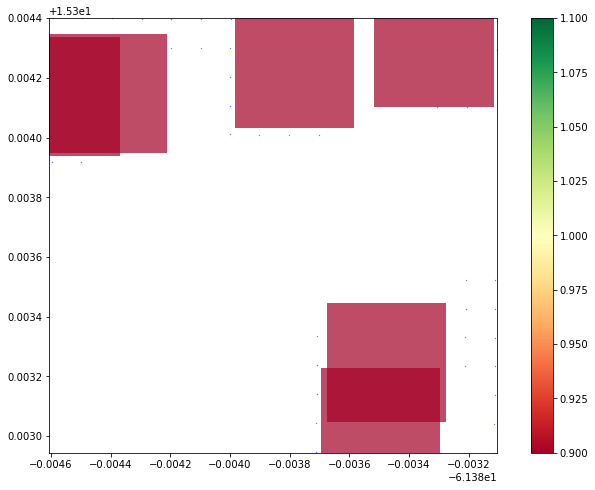

In [13]:
## Plot success of change detection in matplotlib and save figure
# Damage detected true/false
filtered['found'] = pd.Series(acc[filtered.index,0], index=filtered.index)
filtPlot = filtered.plot(figsize=(12,8), column='found',legend=True,cmap='RdYlGn',alpha = 0.7)

# False detection points
points = np.vstack([rec[i] for i in det.index])
x1, y1 = np.array(det.geometry.x)*(1-points).transpose(), np.array(det.geometry.y)*(1-points).transpose()
x1, y1 = x1[x1 != 0], y1[y1 != 0]
filtPlot.scatter(x1,y1,s=0.05,color='b', label='False detections')
filtPlot.set_xlim([tilePoly.bounds[0], tilePoly.bounds[2]])
filtPlot.set_ylim([tilePoly.bounds[1], tilePoly.bounds[3]])

# # Set titles and save
# plt.set_title('Threshold:'+str(threshold)+', Area:'+str(area)+', Kernel:'+str(kSize)+' - Acc:'+str(a[0])[:6]+', Re:'+str(r[0])[:6])
# plt.legend()
# plt.figure.savefig('results/'+location+'_t'+str(threshold)[2:]+'a'+str(area)[2:]+'g'+str(len(grades))+str(bands)+'.png')

## Display on interactive map
# Initialise map
m4 = wf.interactive.MapApp()
m4.center, m4.zoom = (lat, lon), zoom

# Plot background imagery as image 2 using function from map 1
getImage(1,bands,0.7,m4)

det_data = GeoData(geo_dataframe = det, style={'color': 'blue', 'radius':2, 'fillColor': 'blue', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                    point_style={'radius': 3, 'color': 'blue', 'fillOpacity': 0.7, 'fillColor': 'blue', 'weight': 3}, name = 'Damages')
m4.add_layer(det_data)

# Add layers for building polygons whether red for not found, green for found
not_found = GeoData(geo_dataframe = filtered.loc[filtered['found']==0], style={'color': 'red', 'radius':2, 'fillColor': 'red', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                    hover_style={'fillColor': 'red' , 'fillOpacity': 0.5},
                    name = 'Damages')
found = GeoData(geo_dataframe = filtered.loc[filtered['found']==1], style={'color': 'green', 'radius':2, 'fillColor': 'green', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                    hover_style={'fillColor': 'green' , 'fillOpacity': 0.5},
                    name = 'Damages')
m4.add_layer(not_found)
m4.add_layer(found)

# Plot bounding box for damage search
poly = gpd.GeoSeries(Polygon.from_bounds(ctx.bounds[0],ctx.bounds[1],ctx.bounds[2],ctx.bounds[3]), crs={'init':'EPSG:32618'}).to_crs(epsg=4326)
box = GeoData(geo_dataframe = gpd.GeoDataFrame(geometry = poly.envelope), style={'color':'yellow','fillOpacity':0, 'opacity':0.9})
m4.add_layer(box)

# Legend
m4.add_control(LegendControl({"Damage Identified":"#008000", "Damage Not Identified":"#FF0000", "Detected Change":"#0000FF", "Search Area":"#FFFF00"}))

m4

_________________
<a id='TestLocation'></a>
## 7. Test Location
Beyond predicting for a single tile, we would like to evaluate the model's performance over an arbitrary wider area. For this let's draw a polygon over the desired area. Then, each corresponding tile will individually be fed in to the model for assessing change detection. If over a location with ground data, accuracy will then be evaluated for the combined output for all tiles.
> One could question the decision not to just increase tilesize. However not only does this method make the evaluation area more flexible, but also the model does not cater well for tile sizes larger than that for which it was trained due to the input layer structure.

In [14]:
# Display map upon which to draw Polygon for analysis
r = 10*area
testPoly = ipyleaflet.Polygon(locations=[(lat-r, lon-r), (lat-r, lon+r), (lat+r, lon+r),(lat+r, lon-r)], color="yellow", fill_color="yellow", transform=True)

pos = Map(center=(lat, lon), zoom=zoom)
if not deployed:
    pos.add_layer(geo_data)
    pos.add_control(LegendControl({"Recorded Damage":"#FF0000"})) 
pos.add_layer(testPoly)

pos

Map(center=[15.3031, -61.3834], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [15]:
# Define all functions required for obtaining detections
if deployed: # Define functions if not defined in section 5
    # Function retrieving appropriate tile of the ratio
    def get_ratio_image(dltile_key,ratio,tilesize,bands):
        tile = dl.scenes.DLTile.from_key(dltile_key)
        sc, ctx = dl.scenes.search(aoi=tile, products=satellite, start_datetime=st_date[0], end_datetime=end_date[0])
        return ratio.compute(ctx).ndarray.reshape(tilesize,tilesize,len(bands)) 

    # Function retrieving desired tile from Sentinel imagery for display
    def get_sentinel_image(dltile_key, bands):
        tile = dl.scenes.DLTile.from_key(dltile_key)
        sc, ctx = dl.scenes.search(aoi=tile, products=satellite, start_datetime=st_date[0], end_datetime=end_date[0])
        im = sc.mosaic(bands=bands, ctx=ctx, bands_axis=-1)
        return im, ctx
    
    # Function running predict image for each tile
    def predict_image(dltile_key,ratio,tilesize,bands):
        print("Predict on image for dltile {}".format(dltile_key))

        # load model
        model = load_model(modelName)

        # get imagery
        im = get_ratio_image(dltile_key,ratio,tilesize,bands)

        # add batch dimension
        im = np.expand_dims(im, axis=0).astype(np.float32)

        # predict
        pred = model.predict(im)

        return im, pred

## Function to get detections for each tile
def testTile(lat,lon,tilesize,threshold):
    tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution=resolution, tilesize=tilesize, pad=pad) # Convert coordinates to nearest descartes labs tile with size of our choosing

    im, pred = predict_image(tile.key,ratio,tilesize,bands) # Run prediction function for tile
    sent, ctx = get_sentinel_image(tile.key,bands) # Get Sentinel imagery for tile

    disting = pred > threshold # Get damaged predictions
    
    # Extract latitude & longitude of each pixel in prediction (whether true or false)
    bounds, disting = ctx.bounds, disting[0,:,:,0] if len(disting.shape) == 4 else disting # Get bounds from tile and reduce extra dimensionality of classification matrix
    lats, longs = np.linspace(bounds[3],bounds[1],disting.shape[0]), np.linspace(bounds[0],bounds[2],disting.shape[1]) # Vector of lat, longs

    # Create matrix of coordinates for pixels with change detected
    xm, ym = np.meshgrid(longs,lats)
    xc, yc = xm*(disting), ym*(disting)

    # Get geodataframe for pixel points
    df = pd.DataFrame(columns=['Northing', 'Easting'])
    for i,j in zip(np.nonzero(xc)[0], np.nonzero(xc)[1]):
        df = df.append({'Northing': yc[i][j],'Easting': xc[i][j]}, ignore_index=True)
    det = gpd.GeoDataFrame(df, crs={'init':ctx.bounds_crs}, geometry=gpd.points_from_xy(df.Easting, df.Northing)).to_crs({'init': 'epsg:4326'})
    
    return det, ctx    

Looping through tiles may take a while depending on polygon size and tile size. About 8 seconds per tile requested on 16GB RAM.

In [16]:
## Loop through tiles to get all detections
# Get latitudes and longitudes for tiles according to polygon drawn and tilesize
tileLats = np.arange(testPoly.locations[0][0]['lat'],testPoly.locations[0][2]['lat'],resolution*1E-5*tilesize)
tileLons = np.arange(testPoly.locations[0][0]['lng'],testPoly.locations[0][2]['lng'],resolution*1E-5*tilesize)
print("Number of tiles requested:",len(tileLats)*len(tileLons),". Approximately",8*len(tileLats)*len(tileLons),"seconds on 16GB RAM.")
threshold = 0.5

allDet = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
allCtx = np.array([])
for lat in tqdm(tileLats):
    for lon in tqdm(tileLons):
        newDet, newCtx = testTile(lat,lon,tilesize,threshold)
        newDet.index = newDet.index + len(allDet.index)
        allDet = allDet.append(newDet)
        allCtx = np.append([allCtx], [np.array(newCtx.bounds)])

  0%|          | 0/8 [00:00<?, ?it/s]

Number of tiles requested: 48 . Approximately 384 seconds on 16GB RAM.
Predict on image for dltile 16:0:10.0:20:1080:10574

Job ID: 271c50543c002adf2b23d279c5f743d7e8c7a2bba686b3d5
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  


 12%|█▎        | 1/8 [00:14<01:44, 14.88s/it]

Predict on image for dltile 16:0:10.0:20:1081:10574

Job ID: 1e560c173295a26237dce7d94d2af8499455d551a39b6a9e
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  


 25%|██▌       | 2/8 [00:27<01:24, 14.06s/it]

Predict on image for dltile 16:0:10.0:20:1083:10574

Job ID: 6a40449c92d8d1a52ce3e27df7135298bc4985fa54d0c38c
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  


 38%|███▊      | 3/8 [00:37<01:05, 13.02s/it]

Predict on image for dltile 16:0:10.0:20:1084:10574

Job ID: cd9b64cc721aeb29c86ca82bb89e068de0975914a81d3a09
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa314d46b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 50%|█████     | 4/8 [00:49<00:50, 12.54s/it]

Predict on image for dltile 16:0:10.0:20:1085:10574

Job ID: 4b980ee453fb9987229c547075c725867ca3b1640b4b880e
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa314cc2200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 62%|██████▎   | 5/8 [01:00<00:36, 12.19s/it]

Predict on image for dltile 16:0:10.0:20:1086:10574

Job ID: f75460a303c534139f8c0a209530eb86a91636f88a8aac94
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:7 out of the last 7 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa308c1fef0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 75%|███████▌  | 6/8 [01:10<00:22, 11.41s/it]

Predict on image for dltile 16:0:10.0:20:1087:10574

Job ID: 55c81a511b993524bdafceef59f1d1897dfffe2a3dbdf6c2
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:8 out of the last 8 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa308a4f8c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 88%|████████▊ | 7/8 [01:21<00:11, 11.33s/it]

Predict on image for dltile 16:0:10.0:20:1088:10574

Job ID: 7408f1b0d6dbc9c0f0768af3784c2b1f09cd70c94816bbae
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:9 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2fcac05f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



  0%|          | 0/8 [00:00<?, ?it/s]

Predict on image for dltile 16:0:10.0:20:1080:10576

Job ID: c21ff31aa898af89f8d0b5ac5f51db50bb4732db5e64cf30
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:10 out of the last 10 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2f1195950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 12%|█▎        | 1/8 [00:11<01:21, 11.66s/it]

Predict on image for dltile 16:0:10.0:20:1081:10576

Job ID: 66a6066a3b2526fdd02abac6323d4898bef39596c3b4b9cc
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa31445e170> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 25%|██▌       | 2/8 [00:18<01:00, 10.08s/it]

Predict on image for dltile 16:0:10.0:20:1083:10576

Job ID: 50ecf4b5850d5fe3fad68d77e9dad52b8ea8437ba8728b60
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2e58fef80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 38%|███▊      | 3/8 [00:29<00:51, 10.36s/it]

Predict on image for dltile 16:0:10.0:20:1084:10576

Job ID: 00030c0eb59255cccf00f08f709fef31cdb280d0f35b6eb8
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2ddfa7830> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 50%|█████     | 4/8 [00:35<00:36,  9.11s/it]

Predict on image for dltile 16:0:10.0:20:1085:10576

Job ID: b1a6ea69998fbaa58f4c4c8276d6c54c3319835e481d02a9
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2dde1bb90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 62%|██████▎   | 5/8 [00:46<00:29,  9.71s/it]

Predict on image for dltile 16:0:10.0:20:1086:10576

Job ID: cb6f026a13f6af2459a11f5303920893e62371983c0f16da
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2dc71e7a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 75%|███████▌  | 6/8 [00:56<00:19,  9.79s/it]

Predict on image for dltile 16:0:10.0:20:1087:10576

Job ID: 0799ffcd4f0d6ec8e91a7faef97bd7e0288416a4a636841a
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2d2de7200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 88%|████████▊ | 7/8 [01:02<00:08,  8.69s/it]

Predict on image for dltile 16:0:10.0:20:1088:10576

Job ID: fc4d96032cdcfcf7f8e05c15e9a5e70745aace182069a978
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2d14dad40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



  0%|          | 0/8 [00:00<?, ?it/s]

Predict on image for dltile 16:0:10.0:20:1080:10577

Job ID: f2c608d7edb6b0592259144490f61e6795f89d9fc04494df
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2d2c47b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 12%|█▎        | 1/8 [00:13<01:31, 13.07s/it]

Predict on image for dltile 16:0:10.0:20:1081:10577

Job ID: 14f8835b2743533890455152eb8d5a0dfdf65623e9001ede
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2d0accd40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 25%|██▌       | 2/8 [00:24<01:14, 12.50s/it]

Predict on image for dltile 16:0:10.0:20:1083:10577

Job ID: 71893ae6a62d7fdc3d67340045d94a6561b60704a8508e0b
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2ceb9d830> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 38%|███▊      | 3/8 [00:35<01:00, 12.11s/it]

Predict on image for dltile 16:0:10.0:20:1084:10577

Job ID: 4d92d94914a2407f446dc02fbaf4dabfb683a67c914a8125
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2cd2940e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 50%|█████     | 4/8 [00:54<00:56, 14.11s/it]

Predict on image for dltile 16:0:10.0:20:1085:10577

Job ID: 717b819fee03c3296afb98666b98602186ac8386de79dab7
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2cb9a0830> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 62%|██████▎   | 5/8 [01:00<00:35, 11.78s/it]

Predict on image for dltile 16:0:10.0:20:1086:10577

Job ID: 81a07a383707d907fce31ffa7b73df2197503505f9024bae
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2cd24af80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 75%|███████▌  | 6/8 [01:07<00:20, 10.40s/it]

Predict on image for dltile 16:0:10.0:20:1087:10577

Job ID: 2faa670814f8cc7c00f76c971cbfebe4e2f5a73f913e4b4d
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2cd24a290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 88%|████████▊ | 7/8 [01:20<00:10, 10.99s/it]

Predict on image for dltile 16:0:10.0:20:1088:10577

Job ID: 7e972ff2fd9c897e1eef2a86e85377fb2f6a2049dd8082a5
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c98dfef0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



  0%|          | 0/8 [00:00<?, ?it/s]

Predict on image for dltile 16:0:10.0:20:1080:10578

Job ID: 0adc483dba20ed660c98489bf746c316d24f5d5510979e55
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c7fd9d40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 12%|█▎        | 1/8 [00:06<00:45,  6.49s/it]

Predict on image for dltile 16:0:10.0:20:1081:10578

Job ID: f09d770471cdb2caf5b06535a697e3c5d0fa9b4bfd8127b1
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c66e7050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 25%|██▌       | 2/8 [00:13<00:40,  6.71s/it]

Predict on image for dltile 16:0:10.0:20:1083:10578

Job ID: d1668d11495b00d7158e120b10f9e4b6a18f7c5e139d65e3
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa77c379cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 38%|███▊      | 3/8 [00:21<00:34,  6.92s/it]

Predict on image for dltile 16:0:10.0:20:1084:10578

Job ID: 206628d5632bc493cadd2544cedc87f9e38da94a67bda5c3
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c6656950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 50%|█████     | 4/8 [00:27<00:27,  6.75s/it]

Predict on image for dltile 16:0:10.0:20:1085:10578

Job ID: f81d0ba5abdc70b0c9826c1fbf0632c69a6e137a1083d40a
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c45f8320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 62%|██████▎   | 5/8 [00:40<00:25,  8.58s/it]

Predict on image for dltile 16:0:10.0:20:1086:10578

Job ID: bde7aba4b2af1d0db7f6f6523468069f7e59948b462c6120
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c2d01cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 75%|███████▌  | 6/8 [00:51<00:18,  9.22s/it]

Predict on image for dltile 16:0:10.0:20:1087:10578

Job ID: 1f5f11ced3d2a5133cd7edf2a2483f2e4bd97de3fab48e6e
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c1401f80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 88%|████████▊ | 7/8 [00:58<00:08,  8.56s/it]

Predict on image for dltile 16:0:10.0:20:1088:10578

Job ID: d39563999cb1799c57c2c42712b5bcedb64bdbd2d9c52041
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2bfaf8cb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



  0%|          | 0/8 [00:00<?, ?it/s]

Predict on image for dltile 16:0:10.0:20:1080:10579

Job ID: ebfda61b0975b6866ca8123eb12874429f836d8efba54f0e
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2bfaf8a70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 12%|█▎        | 1/8 [00:06<00:47,  6.79s/it]

Predict on image for dltile 16:0:10.0:20:1081:10579

Job ID: e53d926e8ba44597a68765847f0d15762f931eb7aefeedeb
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2bc921290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 25%|██▌       | 2/8 [00:14<00:41,  6.95s/it]

Predict on image for dltile 16:0:10.0:20:1083:10579

Job ID: 9764707a5f2b76308b66ae4f86b9c2d2cfa6047d436c91df
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2bc7ed830> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 38%|███▊      | 3/8 [00:27<00:43,  8.78s/it]

Predict on image for dltile 16:0:10.0:20:1084:10579

Job ID: a640dd1345d4097ad8ce2d8a6f83ebe6431cca726a9f13b7
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2ca47e9e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 50%|█████     | 4/8 [00:35<00:34,  8.65s/it]

Predict on image for dltile 16:0:10.0:20:1085:10579

Job ID: 2cea7e2f1cf4f4de8646bdfa9da2d1561d3197ce92baabd3
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2c3ae9290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 62%|██████▎   | 5/8 [00:47<00:28,  9.56s/it]

Predict on image for dltile 16:0:10.0:20:1086:10579

Job ID: 35069e46f4458390b78b8a175bdfbea74ca4d431c9bacaea
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2ba87c680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 75%|███████▌  | 6/8 [00:59<00:20, 10.46s/it]

Predict on image for dltile 16:0:10.0:20:1087:10579

Job ID: 9ed15ebc81aee6a62b3574b3a816e2a8b6ed74f535514eb0
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b8f8ce60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 88%|████████▊ | 7/8 [01:12<00:11, 11.04s/it]

Predict on image for dltile 16:0:10.0:20:1088:10579

Job ID: 66f13bb5e46ee677cfd41421026fbe79f92e8581e9805518
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b769f050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



  0%|          | 0/8 [00:00<?, ?it/s]

Predict on image for dltile 16:0:10.0:20:1080:10580

Job ID: c4b5ecf2c107c6acd5b37b69665feaf1a6c2a3f5ebbb31b2
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b5d9c7a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 12%|█▎        | 1/8 [00:07<00:49,  7.13s/it]

Predict on image for dltile 16:0:10.0:20:1081:10580

Job ID: 3195c2a3f4524bc19d2cc3329fe27660d818d9b38b9083f8
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b448e290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 25%|██▌       | 2/8 [00:20<00:53,  8.94s/it]

Predict on image for dltile 16:0:10.0:20:1083:10580

Job ID: 104f7a7cf4f4f117168c6df0fb98d2b127e021295f237697
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b2bc9a70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 38%|███▊      | 3/8 [00:29<00:45,  9.11s/it]

Predict on image for dltile 16:0:10.0:20:1084:10580

Job ID: f6a9fcaf444d808ab671be2909e75909aa05e0ae3db9bf2a
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b43083b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 50%|█████     | 4/8 [00:42<00:41, 10.25s/it]

Predict on image for dltile 16:0:10.0:20:1085:10580

Job ID: 4cc5c0dd4537c4cb39e4a348e2e6c33d09309b2a21d8f8f8
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2bdb1e710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 62%|██████▎   | 5/8 [00:50<00:28,  9.49s/it]

Predict on image for dltile 16:0:10.0:20:1086:10580

Job ID: f306a86316941b10c7dd1e230ed3873f74ffeabfec0f8962
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b24475f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 75%|███████▌  | 6/8 [01:03<00:21, 10.52s/it]

Predict on image for dltile 16:0:10.0:20:1087:10580

Job ID: b254c1b33f113aecfc99ef25dcc25de9a962b5fb7fe72c41
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2b0b49320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



 88%|████████▊ | 7/8 [01:10<00:09,  9.66s/it]

Predict on image for dltile 16:0:10.0:20:1088:10580

Job ID: 072ab9dfe6d87e72cbb1dde7ce18d8e750e13f373c1d9de7
[######] | Steps: 109/109 | Stage: SUCCEEDED                                  WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa2af2434d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



100%|██████████| 6/6 [07:49<00:00, 78.28s/it]


In [17]:
## Evaluate against damages
if not deployed:
    # Load building damages and filter for within detection area
    dmg = gpd.read_file(dmgJsons)
    filtered = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})

    tilePoly = gpd.GeoSeries(Polygon.from_bounds(min(allCtx[0::4]),min(allCtx[1::4]),max(allCtx[2::4]),max(allCtx[3::4])), crs={'init':ctx.bounds_crs}).to_crs(epsg=4326).geometry[0]
    for i in dmg.index: 
        if dmg.geometry[i].centroid.within(tilePoly):
            filtered = filtered.append(dmg.loc[i])

    print('Changed pixels:',len(allDet), '\nDamaged buildings:',len(filtered))

    # Initialise accuracy and recall vectors
    acc, rec = np.zeros([max(filtered.index)+1,1]), np.zeros([max(allDet.index)+1,1]) # Initialise accuracy, recall arrays

    # Loop through pixels to determine recall (if pixel corresponds to damaged building)
    for i in tqdm(allDet.index):
        # Loop through building to determine accuracy (damaged building has been detected)
        for j in filtered.index:
            if allDet.geometry[i].within(filtered.geometry[j]):
                rec[i,0], acc[j,0] = True, True

    # Calculate metrics from vector outputs
    a = sum(acc)/len(filtered)
    r = sum(rec)/len(allDet)
    f1 = 2*(a*r)/(a+r)
    print('Accuracy:',a[0],'\nRecall:',r[0],'\nF1 score:',f1[0])    

  0%|          | 3/4808 [00:00<02:44, 29.28it/s]

Changed pixels: 4808 
Damaged buildings: 700


100%|██████████| 4808/4808 [03:10<00:00, 25.26it/s]

Accuracy: 0.7185714285714285 
Recall: 0.8566971713810316 
F1 score: 0.7815785959435083


In [21]:
# Initialise map
m5 = wf.interactive.MapApp()
m5.center, m5.zoom = (lat, lon), zoom

getImage(1,bands,0.7,m5) # Display sentinel imagery using function from map 1

# Ass layer for detections from model
allDet_data = GeoData(geo_dataframe = allDet, style={'color': 'yellow', 'radius':2, 'fillColor': 'yellow', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                    point_style={'radius': 2, 'color': 'yellow', 'fillOpacity': 0.7, 'fillColor': 'blue', 'weight': 3}, name = 'Damages')
m5.add_layer(allDet_data)

# Add layers for building polygons whether red for not found, green for found
if not deployed:
    filtered['found'] = pd.Series(acc[filtered.index,0], index=filtered.index)
    all_not_found = GeoData(geo_dataframe = filtered.loc[filtered['found']==0], style={'color': 'red', 'radius':2, 'fillColor': 'red', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                        hover_style={'fillColor': 'red' , 'fillOpacity': 0.5},
                        name = 'Damages')
    all_found = GeoData(geo_dataframe = filtered.loc[filtered['found']==1], style={'color': 'green', 'radius':2, 'fillColor': 'green', 'opacity':0.7, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                        hover_style={'fillColor': 'green' , 'fillOpacity': 0.5},
                        name = 'Damages')
    m5.add_layer(all_not_found)
    m5.add_layer(all_found)
    
    # Legend
    m5.add_control(LegendControl({"Damage Identified":"#008000", "Damage Not Identified":"#FF0000", "Detected Change":"#0000FF", "Search Area":"#FFFF00"}))
else: 
    m5.add_control(LegendControl({"Detected Change":"#FFFF00", "Search Area":"#0000FF"}))
    

# Plot bounding box for damage search
testPoly.color, testPoly.fill_opacity = 'blue', 0
m5.add_layer(testPoly)

m5


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


## --------- END ----------